In [1]:
# The spelled-out intro to neural networks and backpropagation: building micrograd(https://youtu.be/VMj-3S1tku0?si=CnyW5BFfHFfUiDjF)


[]

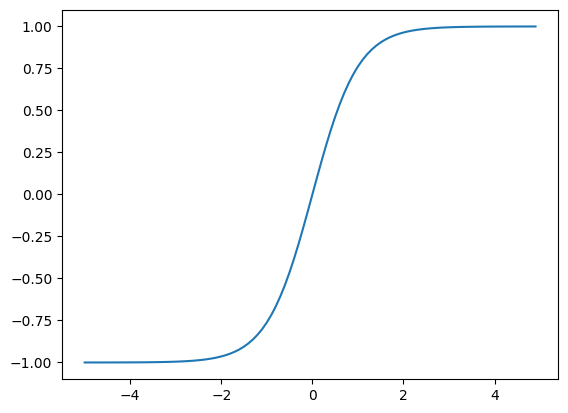

In [2]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(np.arange(-5,5,0.1), np.tanh(np.arange(-5,5,0.1)))
plt.plot()

def tanh(inputs):
    outputs = []
    for x in inputs
        exp2X = math.exp(2.0*x)
        t = (exp2X-1)/(exp2X+1)
        outputs.append(t)
    return out


In [20]:
from graphviz import Digraph
import math

class Value:
    operator_precedence = {'+':1,'-':1,'*':2,'/':2, 'tenh':10, '**':9, 'exp':9}
    
    def _draw_self(self, dot, draw_operators = False):
        uid = str(id(self))
        dot.node(uid, label = '{%s | data %.4f | grad %.4f}' % (self.label, self.data, self.grad), shape='record')
        if draw_operators and self._op:
                dot.node(name = uid + self._op, label = self._op)
                dot.edge(uid + self._op, uid)#op->value
                for n in self._prev:
                    dot.edge(str(id(n)), uid + self._op )#prev->operator
                    n._draw_self(dot, draw_operators)
        else:
            for n in self._prev:
                    dot.edge(str(id(n)), str(id(self)))#prev->self
                    n._draw_self(dot, draw_operators)

    def draw(self, draw_operators = False):
        dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
        self._draw_self(dot, draw_operators)
        return dot

    def label_from(self, other, op):
        self_part = ''
        other_part = ''
        if self._op and Value.operator_precedence[self._op] < Value.operator_precedence[op]:
            self_part = f'({self.label})'
        else:
            self_part = self.label

        if other._op and Value.operator_precedence[other._op] < Value.operator_precedence[op]:
            other_part = f'({other.label})'
        else:
            other_part = other.label
        return f'{self_part}{op}{other_part}'
                
    def __init__(self, data, _prev=(), _op='', label = ''):
        self.data = data
        self._prev = set(_prev)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def backward(self):
        self.grad = 1.0
        
        topo = []
        stack=[]
        stack.append(self)
        visited = {}
        while len(stack) != 0:
            v = stack.pop()
            if v in visited:
                index = visited[v]
                topo.pop(index)
                for ov in visited:
                    if visited[ov] > index:
                        visited[ov] = visited[ov] - 1
            visited[v] = len(topo)
            topo.append(v)
            for n in v._prev:
                stack.append(n)
    
        for n in topo:
            n._backward()

    def backward_recursive(self):
        self.grad = 1.0
        visited = set()
        topo = []
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for n in v._prev:
                    build_topo(n)
                topo.append(v)
        build_topo(self)
    
        for n in reversed(topo):
            n._backward()

    def __repr__(self):
        return f'Value(data={self.data}, grad={self.grad}, label={self.label})'

    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other, label='%.4f' % other )
        out = Value(self.data + other.data, (self,other), '+', self.label_from(other,'+') )
        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other):
        return self + other;

    def __mul__(self, other):
        assert id(other) != id(self)
        other = other if isinstance(other,Value) else Value(other, label='%.4f' % other )
        out = Value(self.data * other.data, (self,other), '*', self.label_from(other,'*'))
        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def __truediv__(self,other):
        other = other if isinstance(other,Value) else Value(other, label='%.4f' % other )
        out = self * other**-1
        return out

    def __rtruediv__(self, other):
        other = other if isinstance(other,Value) else Value(other, label='%.4f' % other )
        return other/self

    def __pow__(self, other):
        assert isinstance(other,(int,float)), 'pow accepts only ints or floats'
        out = Value(self.data**other, (self, ), '**', f'{self.label}**{other}')
        def _backward():
            self.grad  += (other*self.data**(other - 1))*out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1.0

    def __sub__(self, other):
        return self + -other

    def __rsub__(self, other):
        return -self + other

    def tanh(self):
        x = self.data
        exp2X = math.exp(2.0*x)
        t = (exp2X-1)/(exp2X+1)
        out = Value(t, (self, ), 'tanh', f'tanh({self.label})')
        def _backward():
            self.grad  += (1 - t**2)*out.grad
        out._backward = _backward
        return out

    def tanh_slow(self):
        e = (2.0*self).exp()
        return (e-1)/(e+1)
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp', f'exp({self.label})')
        def _backward():
            self.grad  += out.data*out.grad
        out._backward = _backward
        return out

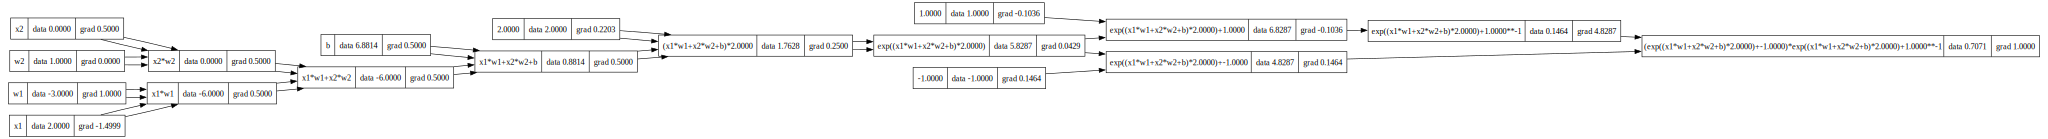

In [24]:
def test_0():
    x1 = Value(2.0, label = 'x1')
    x2 = Value(0.0, label = 'x2')
    w1 = Value(-3.0, label = 'w1')
    w2 = Value(1.0, label = 'w2')
    b = Value(6.8814, label = 'b')
    x1w1 = x1*w1
    x2w2 = x2*w2
    x1w1x2w2 = x1w1 + x2w2 
    pre_out = x1w1x2w2 + b
    out = (pre_out).tanh_slow()

    out.backward()

    return out.draw()
test_0()

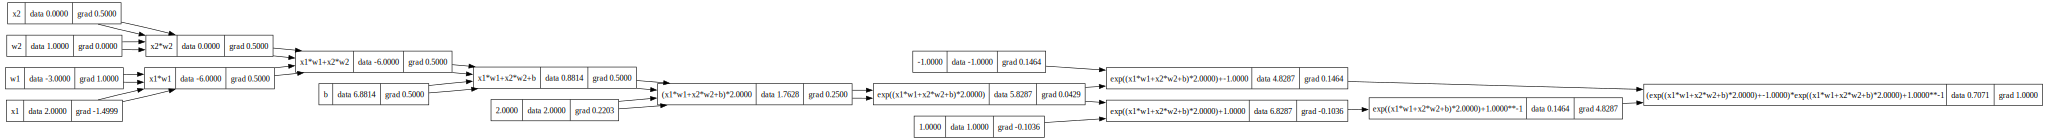

In [25]:
def test_1():
    x1 = Value(2.0, label = 'x1')
    x2 = Value(0.0, label = 'x2')
    w1 = Value(-3.0, label = 'w1')
    w2 = Value(1.0, label = 'w2')
    b = Value(6.8814, label = 'b')
    x1w1 = x1*w1
    x2w2 = x2*w2
    x1w1x2w2 = x1w1 + x2w2 
    pre_out = x1w1x2w2 + b
    out = (pre_out).tanh_slow()

    out.backward_recursive()

    return out.draw()
test_1()